# Constraining Cosmological Parameters by Using Lensing Data

## 1. Data Preparation

In this notebook, we will use data from strong gravitational lensing observation to constrain various cosmological parameters. This work utilizes Leaf & Melia (2018; https://arxiv.org/abs/1805.08640) paper as the main reference. The data was taken from their Table 1.

In [2]:
# import necessary modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline  

# set basic figure parameters
import matplotlib as mpl
mpl_param = {'figure.figsize'   : [8.0, 6.0],
             'savefig.dpi'      : 100,
             'axes.titlesize'   : 'xx-large',
             'axes.labelsize'   : 'xx-large',
             'text.usetex'      : False,
             'font.family'      : 'serif'}
mpl.rcParams.update(mpl_param)


# read lensing data which is taken from Leaf et al. (2018)
data = pd.read_csv('lensing_data.csv')

data = data[data.name != 'J0850-0347'] # outlier removal

# top rows in the data
data.head()

,name,zl,zs,sigma_ap,err_sigma_ap,theta_E,survey,theta_ap,theta_eff,sigma_0,err_sigma_0
0,J0151+0049,0.517,1.364,219,39,0.68,BELLS,1.0,0.89,226,40
1,J0747+4448,0.437,0.897,281,52,0.61,BELLS,1.0,1.24,286,53
2,J0747+5055,0.438,0.898,328,60,0.75,BELLS,1.0,2.87,323,59
3,J0801+4727,0.483,1.518,98,24,0.49,BELLS,1.0,0.57,103,25
4,J0830+5116,0.530,1.332,268,36,1.14,BELLS,1.0,1.10,274,37


In lensing system, we have so called $D$ parameter, which can be derived from observation and defined as:
\begin{equation}
    D^{\rm obs} = \frac{c^2 \theta_{\rm E}}{4 \pi \sigma_0^2}
\end{equation}

where the measurements error can be propagated with

\begin{equation}
    \sigma_{D^{\rm obs}} = D^{\rm obs} \sqrt{\bigg(\frac{\sigma_{\theta_{\rm E}}}{\theta_{\rm E}}\bigg)^2 + \bigg( \frac{2 \sigma_{\sigma_0}}{\sigma_0}\bigg)^2 + \sigma_X^2}
\end{equation}

Therefore, we can write the equation above into the codes below.

In [2]:
# define function to calculate angular diameter distance as in Equation 3
# this is used for observational data
def D_obs(theta_E, sigma_0):
    
    # need to convert theta_E from arcsec to radian
    theta_E = np.deg2rad(theta_E/3600)
    
    # speed of light in km/s
    c = 3*1e5 
    
    return c**2 * theta_E / (4*np.pi * sigma_0**2)

# error of observed angular diameter distance as in Equation 10
# this doesn't include the sigma_x
def D_obs_err(theta_E, err_theta_E, sigma_0, err_sigma_0):
    
    # systematic error
    sigma_X = 0.12
    
    return D_obs(theta_E, sigma_0) \
            * np.sqrt((err_theta_E/theta_E)**2 \
            + (2*err_sigma_0/sigma_0)**2 \
            + sigma_X**2)

In [3]:
# calculate the angular diameter distance
Dobs = D_obs(data['theta_E'], data['sigma_0'])
Dobs_err = D_obs_err(data['theta_E'], data['theta_E']*0.05, data['sigma_0'], data['err_sigma_0'])

(0, 2)

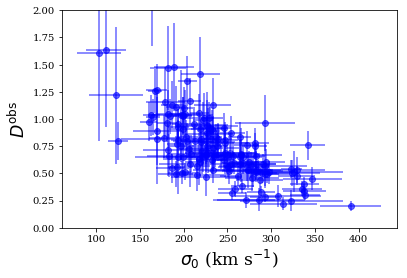

In [4]:
# plot as in Figure 2 in their paper

plt.errorbar(x=data['sigma_0'].values, 
             y=Dobs.values, 
             xerr=data['err_sigma_0'].values,
             yerr=Dobs_err.values,
             fmt='bo', alpha=0.6)

plt.xlabel('$\sigma_0$ (km s$^{-1}$)')
plt.ylabel('$D^{\\rm obs}$')
plt.ylim(0, 2)

As we can see that there are some objects with $D^{\rm obs} > 1$. For a best fitting result, we have to exclude these outliers.

In [5]:
# cut outliers based on page 3 in the paper
data = data[Dobs < 1]

# recalculate the angular diameter distance
Dobs = D_obs(data['theta_E'], data['sigma_0'])
Dobs_err = D_obs_err(data['theta_E'], data['theta_E']*0.05, 
                     data['sigma_0'], data['err_sigma_0'])

## 2. Angular Diameter Distance

Theoretically, the angular diameter distance for certain cosmological model can be described as this equation:

\begin{equation}
    D(z_1, z_2) = \frac{c}{H_0 (1+z_2)} 
        \times \int_{z_1}^{z_2}{
            \frac{dz'}{\sqrt{
                \Omega_{\rm m}(1+z')^3 + \Omega_{\rm r}(1+z')^4 + \Omega_{\rm de}(1+z')^{3(1+w_{\rm de})
               }}}}
\end{equation}

Then, the $D^{\rm th}$ is defined as

\begin{equation}
    D^{\rm th} = \frac{D(z_1, z_2)}{D(0, z_2)}
\end{equation}

Clearly, $D$ does not depend on $H_0$ for any considered models. These equations can be written as below.

In [6]:
from scipy import integrate

# make angular diameter distance calculator
# equivalent to astropy model for cosmolo.angular_diameter_distance_z1z2()
# based on Equation 4 in Leaf et al. (2018)
def ang_dist (z_1, z_2, Omega_m, Omega_lambda, wde):
    
    Omega_r = 0
    
    # integration part
    # integration is calculated from redshift=z_lensing to redshift=z_source
    fn = lambda z: (Omega_r*(1+z)**4. \
                    + Omega_m*(1+z)**3 \
                    + Omega_lambda*(1+z)**(3*(1+wde)) \
                    )**-0.5

    # return array values
    return c/(H0*(1+z_2)) \
        * np.asarray([integrate.quad(fn, _z[0], _z[1])[0] for _z in list(zip(z_1, z_2))])


# D theoretical based on Equation 7 in Leaf et al. (2018)
def D_theory(X, Omega_m, Omega_lambda, wde):
    z_1, z_2 = X
    return ang_dist(z_1, z_2, Omega_m, Omega_lambda, wde) \
            / ang_dist(0*z_1, z_2, Omega_m, Omega_lambda, wde)

## 3. Maximum Likelihood Fitting

We will use maximization of the likelihood function to constrain and compare the models. First, we calculate $D^{\rm obs}$ and $D^{\rm th}$. Then, the join likelihood function for all parameters, based on a flat Bayesian prior, is

\begin{equation}
    \mathcal{L} = \prod_{i} \frac{1}{\sqrt{2 \pi} \sigma_{D_i}} \exp{\bigg[-\frac{\chi^2}{2} \bigg]}
\end{equation}

where for each measurement

\begin{equation}
    \chi^2_i = \frac{(D_i^{\rm obs} - D_i^{\rm th})^2}{\sigma^2_{D_i}}
\end{equation}

In python, those equations can be written as below.

In [7]:
# define likelihood function as in Equation 11 in Leaf et al. (2018)
def lnlike(theta, X, y, yerr):

    Omega_m, Omega_lambda, wde = theta
    model = D_theory(X, Omega_m, Omega_lambda, wde)

    # chi-square
    chi2 = ((y-model)**2)/yerr**2

    return np.sum(1/(np.sqrt(2*np.pi)*yerr) * (np.exp(-chi2/2)))

In [8]:
# assign input parameters to new variables
X = (data['zl'].values, data['zs'].values)
y = Dobs
yerr = Dobs_err

# some constants
c = 3 * 1e5 # km/s
H0 = 67.7 #km / (Mpc s)

# Omega_m, Omega_lambda, wde
initial_params = [0.3, 0.7, -1]


from scipy import optimize

# optimize module minimizes functions whereas we would like to maximize the likelihood
# that's why I put the minus(-) sign
nll = lambda *args: -lnlike(*args)
result = optimize.minimize(nll, initial_params, args=(X, y, yerr))
m_ml, b_ml, wde_ml = result["x"]

print ('======================================')
print ('Maximum Likelihood Result')
print ('Omega_m = %.2f (%f)' %(m_ml, 0))
print ('Omega_lambda = %.2f (%f)' %(b_ml, 0))
print ('w_de = %.2f (%f)' %(wde_ml, 0))
print ('======================================')

Maximum Likelihood Result
Omega_m = 2.65 (0.000000)
Omega_lambda = 3.72 (0.000000)
w_de = -3.70 (0.000000)


The result is far from current known value. Therefore, we need to improve the fitting method.

## 4. Markov Chain Monte Carlo Fitting

In order to improve our fitting accuracy, we will use emcee, which is pure-Python implementation of Goodman & Weare's Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler. These pages (http://emcee.readthedocs.io/en/stable/) will show you how to use it. We would like to marginalize over some "nuisance parameters" and find an estimate of the posterior probability function (the distribution of parameters that is consistent with dataset) for others. 

We will define uniform (so-called "uninformative") priors on initial parameters ($\Omega_{\rm m}$, $\Omega_{\Lambda}$, and $w_{\rm de}$). Then, combining this with the definition of lnlike from above, the full log-probability function can be calculated.

In [9]:
# define prior for LambdaCDM cosmology model
def lnprior(theta):
    Omega_m, Omega_lambda, wde = theta
    
    if -1.05 <= wde <= -0.95 \
    and 0.95 <= Omega_m + Omega_lambda <= 1.05:
        return 0
    return -np.inf

# define the full probability
def lnprob(theta, X, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, X, y, yerr)

Next, we start by initializing the walkers in a tiny Gaussian ball around the maximum likelihood result and set up the sampler.

In [10]:
# 3 parameters to fit and set up 100 walkers
ndim, nwalkers = 3, 500

# initiate walkers position around initial parameters
pos = [initial_params + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]


import emcee
import sys

# set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(X, y, yerr), threads=3)

# number of iteration, along with progress bar width
nsteps = 1000
width = 30

print ('running MCMC.....')

# run the MCMC
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    n = int((width+1) * float(i) / nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
sys.stdout.write("\n")

# take the sampler after 50 steps
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

running MCMC.....
[                              ]

/home/irhamta/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/home/irhamta/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


[                              ]

/home/irhamta/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/home/irhamta/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


[#                             ]

/home/irhamta/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/home/irhamta/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


[##############################]


The walkers start in small distributions around the maximum likelihood values and then they quickly wander and start exploring the full posterior distribution. In fact, after fewer than 50 steps, the samples seem pretty well "burnt-in". That is a hard statement to make quantitatively but for now, we will just accept it and discard the initial 50 steps and flatten the chain so that we have a flat list of samples

Now that we have this list of samples, let's make one of the most useful plots you can make with your MCMC results: a corner plot.

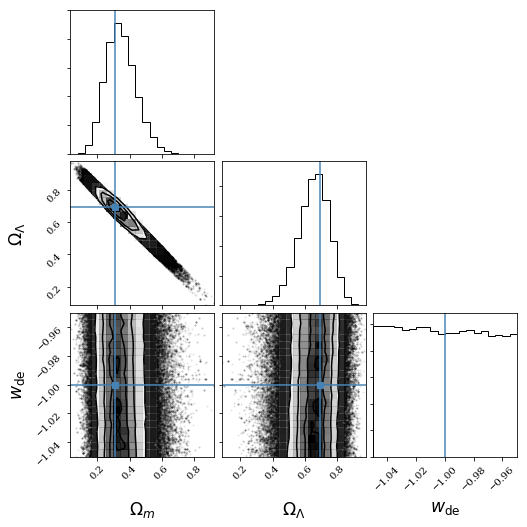

MCMC Result
Omega_m =  (0.34048431443531274, 0.10103403734940442, 0.08706325618191274)
Omega_lambda =  (0.6589256228956146, 0.0889932716335613, 0.10136868781901331)
w_de =  (-1.0010306193840321, 0.034409158635740345, 0.03356387843962905)


In [11]:
import corner

Omega_m = 0.307
Omega_r = 0 * 1e-5 # too small, so I just set it to zero
Omega_lambda = 1 - Omega_m
wde = -1

# plot parameter distributions
fig = corner.corner(samples, labels=["$\Omega_m$", "$\Omega_\Lambda$", "$w_{\\rm de}$"],
                      truths=[Omega_m, Omega_lambda, wde])

plt.savefig('result/lensing.png')
plt.show()


# obtain the value
m_mcmc, b_mcmc, wde_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

print ('============================================================================')
print ('MCMC Result')
print ('Omega_m = ', m_mcmc)
print ('Omega_lambda = ', b_mcmc)
print ('w_de = ', wde_mcmc)
print ('============================================================================')


# save obtained parameters
output_data = pd.DataFrame({'omega_m': samples[:, 0], 
                            'omega_l': samples[:, 1],
                            'wde'    : samples[:, 2]})
output_data.to_csv('result/output_lensing.csv', index=False)

As the final result, we obtained best parameters for $\Lambda$CDM cosmology as:

$\Omega_{\rm m} = 0.33_{-0.10}^{+0.09}$

$\Omega_\Lambda = 0.67_{-0.09}^{+0.10}$

$w_{\rm de} = -1.00_{-0.03}^{+0.04}$

which is consistent compared to Leaf & Melia (2018) result. Then, we can overplot the lensing contour result with other observations, such as Planck's CMB and supernova type Ia observation.

/home/irhamta/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label'
  s)


(0.6, 0.8)

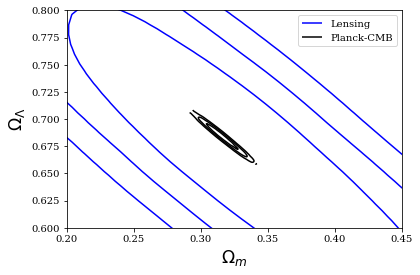

In [3]:
# =============================================================================
# Plot Lensing Result
# =============================================================================

from scipy import ndimage

lensing_data = pd.read_csv('result/output_lensing.csv')


H_lensing, xbins_lensing, ybins_lensing = np.histogram2d(lensing_data['omega_m'], 
                                                          lensing_data['omega_l'], 
                                                          bins=100)

H_lensing = ndimage.gaussian_filter(H_lensing, 2)
sortH_lensing = np.sort(H_lensing.flatten())
cumH_lensing = sortH_lensing.cumsum()
lvl68_lensing = sortH_lensing[cumH_lensing > cumH_lensing.max()*0.32].min()
lvl95_lensing = sortH_lensing[cumH_lensing > cumH_lensing.max()*0.05].min()
lvl99_lensing = sortH_lensing[cumH_lensing > cumH_lensing.max()*0.003].min()


c1 = plt.contour(H_lensing.T, [lvl99_lensing, lvl95_lensing, lvl68_lensing], colors='b', 
                 extent=(xbins_lensing[0], xbins_lensing[-1], ybins_lensing[0], ybins_lensing[-1]),
                 label='Lensing')

c1.collections[0].set_label('Lensing')


# =============================================================================
# Plot CMB data from Planck observation
# =============================================================================

# path to data planck data folder
path = './'

# MCMC chain samples
cmb_data = np.loadtxt(path + 'base_plikHM_TTTEEE_lowl_lowE_lensing_1.txt')

# load the column names for the samples
column_names = np.loadtxt(path + 'base_plikHM_TTTEEE_lowl_lowE_lensing.paramnames',
                          dtype=np.str, usecols=[0])

# make a data frame with column names and samples
# first two columns are not important
planck = pd.DataFrame(cmb_data[:,2:], columns=column_names)


# insert parameters to variable
planck_omegaM = planck['omegam*']
planck_omegaL = planck['omegal*']


H, xbins, ybins = np.histogram2d(planck_omegaM ,planck_omegaL, bins=100)

H = ndimage.gaussian_filter(H, 2)
sortH = np.sort(H.flatten())
cumH = sortH.cumsum()
lvl68 = sortH[cumH > cumH.max()*0.32].min()
lvl95 = sortH[cumH > cumH.max()*0.05].min()
lvl99 = sortH[cumH > cumH.max()*0.003].min()

c0 = plt.contour(H.T, [lvl99, lvl95, lvl68],
              colors='k', extent=(xbins[0], xbins[-1], ybins[0], ybins[-1]),
              label='Planck')
c0.collections[0].set_label('Planck-CMB')



# =============================================================================
# Plot Supernova Result
# =============================================================================

supernova_data = pd.read_csv('result/output_supernova.csv')


H_supernova, xbins_supernova, ybins_supernova = np.histogram2d(supernova_data['omega_m'], 
                                                               supernova_data['omega_l'], 
                                                               bins=100)



H_supernova = ndimage.gaussian_filter(H_supernova, 2)
sortH_supernova = np.sort(H_supernova.flatten())
cumH_supernova = sortH_supernova.cumsum()
lvl68_supernova = sortH_supernova[cumH_supernova > cumH_supernova.max()*0.32].min()
lvl95_supernova = sortH_supernova[cumH_supernova > cumH_supernova.max()*0.05].min()
lvl99_supernova = sortH_supernova[cumH_supernova > cumH_supernova.max()*0.003].min()

#c2 = plt.contour(H_supernova.T, [lvl99_supernova, lvl95_supernova, lvl68_supernova], colors='r', 
#                 extent=(xbins_supernova[0], xbins_supernova[-1], ybins_supernova[0], ybins_supernova[-1]),
#                 label='Lensing')
#c2.collections[0].set_label('Supernova')

plt.xlabel('$\Omega_m$')
plt.ylabel('$\Omega_\Lambda$')
plt.legend()
plt.xlim(0.2, 0.45)
plt.ylim(0.6, 0.8)